# Path Average Rain Rate Estimation

> This module contains methods for estimating rain rates from path-integrated attenuation (PIA). Currently, we compute the time-mean total precipitation rate as defined by [ECMWF](https://codes.ecmwf.int/grib/param-db/172228), using `tprate` as the variable name for simplicity. Note that while ECMWF uses units of $m·s^{-1}$, we may use different units such as $mm·h^{-1}$.

In [ ]:
#| default_exp rrate

In [ ]:
#| export
#| hide
import pandas as pd
import xarray as xr

In [ ]:
#| hide
import matplotlib.pyplot as plt
from raincell import open_cml_sample

In [ ]:
cml, baseline = open_cml_sample(), open_cml_sample("baseline")

## k-R law for Network Management System (NMS) min/max sampling

The rain rate ($R$) can be estimated from the specific attenuation ($k$) expressed in $dB·km^{-1}$ using an exponential law known as the k-R relationship:
$$
k = aR^b
$$
where $a$ and $b$ are parameters that depend on the frequency, polarisation and drop size distribution (DSD). However, the available attenuation is the Path Integrated Attenuation:
$$
PIA = \int_0^L k(l) \, dl
$$
where $L$ is the length of the link. We are interested in the path-averaged rain rate $\bar{R}$, and the above relationship can be approximated as:
  
$$
PIA = \int_0^L k(l) \, dl = \int_0^L a R(l)^b \, dl \stackrel{b \approx 1}{=} a \bar{R}^b L
$$
The further $b$ deviates from 1, the more imprecise this relationship becomes. If attenuation sampling is not instantaneous (e.g., 15 minutes), PIA is also time-averaged; thus $\bar{R}$ becomes the time-mean path-averaged precipitation rate.

Considering that the sample data is located in Douala, and that the $a$ and $b$ coefficients are dependent on the DSD, which varies by region, we will first develop the coefficients estimated by Alcoba (2019).

In [ ]:
#| export
def alcoba_2019_africa_coefs() -> xr.Dataset:
    """ k-R relationship coefficients for Africa from [Alcoba (2019)](https://theses.hal.science/tel-02955598/). """
    coefs = {
        "7.0":{"a":0.000197,"b":1.854},
        "8.5":{"a":0.0066,"b":1.2897},
        "11.0":{"a":0.0195,"b":1.1951},
        "11.5":{"a":0.023,"b":1.1775},
        "13.0":{"a":0.0347,"b":1.1333},
        "14.5":{"a":0.0473,"b":1.1022},
        "15.0":{"a":0.0517,"b":1.0943},
        "18.0":{"a":0.0781,"b":1.0654},
        "19.0":{"a":0.0873,"b":1.06},
        "22.0":{"a":0.1171,"b":1.0471},
        "23.0":{"a":0.1281,"b":1.0428}
        }

    coefs = xr.Dataset(
        data_vars={
            "a": ("frequency", [c["a"] for c in coefs.values()]),
            "b": ("frequency", [c["b"] for c in coefs.values()])
        },
        coords={"frequency": [int(float(f) * 1e3) for f in coefs.keys()]} # Convert to MHz to match OpenSense standard
    )
    coefs["frequency"].attrs["units"] = "MHz"
    return coefs   

In [ ]:
alcoba_2019_africa_coefs().to_dataframe()

,a,b
frequency,,
7000,0.000197,1.8540
8500,0.006600,1.2897
11000,0.019500,1.1951
11500,0.023000,1.1775
13000,0.034700,1.1333
14500,0.047300,1.1022
15000,0.051700,1.0943
18000,0.078100,1.0654
19000,0.087300,1.0600


:::{.callout-warning}
While different coefficient assignment algorithms are available (see below), they all based on some form of nearest value. If your frequencies differ significantly from those listed, you may need to use a downscaling algorithm (such as interpolation) to generate coefficients for your specific frequencies before estimating rainfall.
:::

In many scenarios, NMS only save the min and max values for the sampling interval. Thus rain rate has to be estimated from those values. Overeem et al. (2013), developped an algorithm that computes time mean path averaged rain rate for 15 minute interval sampling based only on minimum and máximum values. The algorith asumes that the TSL is constant for each time. Thus máximum and mínimum attenuations are computed as follows:

$$
A_{min} = (TSL - RSL_{min}) - baseline
$$

$$
A_{max} = (TSL - RSL_{max}) - baseline
$$

Then rain rate is estimated as follows.

$$
\bar{R}_{min | max} = a \left(\frac{A_{min|max} - WAA}{L}\right)^b H(A_{min|max} - WAA) \quad
$$

[<matplotlib.lines.Line2D>]

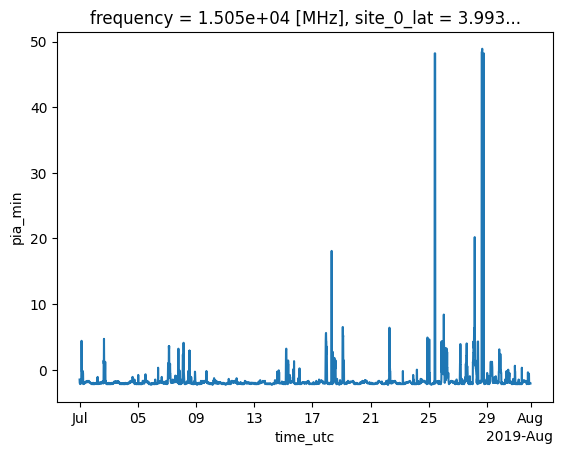

In [ ]:
#| hide
att_rain = (cml["tsl_max"] - cml["rsl_max"]).to_dataset(name="Amax")
att_rain["Amin"] = cml["tsl_min"] - cml["rsl_min"]
att_rain -= baseline
pia = att_rain - 2.3 # Remove WAA
pia = pia.rename({"Amin": "pia_min", "Amax": "pia_max"})
pia.pia_min.isel(cml_id=0, sublink_id=0).plot()

In [ ]:
#| hide
pia_max = pia.isel(cml_id=0, sublink_id=slice(0, 1)).max(dim="time").to_dataframe()
pia_max

,frequency,site_0_lat,site_0_lon,site_1_lat,site_1_lon,transmitter,length,cml_id,pia_max,pia_min
sublink_id,,,,,,,,,,
0_0,15047.0,3.992722,9.787167,3.97665,9.791866,0.0,1852.0,3.984686N-9.789517E,60.4,48.9


In [ ]:
#| hide
alpha = 0.3
a = 0.051700 # a for 15GHz
b = 1.0943 # b for 15GHz
l = pia_max.iloc[0].length * 1e-3 # length in km
alpha * (a * (118.3 / l) ** b) + (1-alpha) * (a * (106.8 / l) ** b)

np.float64(4.5251866333011055)

In [ ]:
#| hide
cfs = alcoba_2019_africa_coefs().sel(frequency=pia.frequency, method="nearest")
cfs

<xarray.Dataset> Size: 39kB
Dimensions:      (cml_id: 126, sublink_id: 6)
Coordinates: (9)
Data variables:
    a            (cml_id, sublink_id) float64 6kB 0.0517 0.0473 ... 0.1281
    b            (cml_id, sublink_id) float64 6kB 1.094 1.102 ... 1.043 1.043

In [ ]:
#| hide
cfs = cfs.drop_vars([c for c in cfs.coords if c not in cfs.dims])
cfs

<xarray.Dataset> Size: 22kB
Dimensions:     (cml_id: 126, sublink_id: 6)
Coordinates: (2)
Data variables:
    a           (cml_id, sublink_id) float64 6kB 0.0517 0.0473 ... 0.1281 0.1281
    b           (cml_id, sublink_id) float64 6kB 1.094 1.102 ... 1.043 1.043

In [ ]:
#| exporti
def reindex_coefs(
        pia: xr.Dataset, # ds containing path integrated attenuation
        coefs: xr.Dataset, # ds containing a and b, k-R law coefficients with frequency dim
        method: str = "nearest" # xr.sel method used to map the pia frequencies to the coefs freqs
    ):
    """Reindex k-R coefficients to match the path integrated attenuation dataset."""
    coefs = coefs.sel(frequency=pia.frequency, method=method)
    return coefs.drop_vars([c for c in coefs.coords if c not in coefs.dims])

$H(x)$ is the Heaviside step function, defined as:

$$
H(x) = \begin{cases}
0 & \text{if } x \leq 0 \\
1 & \text{if } x > 0
\end{cases}
$$


In [ ]:
#| hide
H = pia > 0
H

<xarray.Dataset> Size: 5MB
Dimensions:      (cml_id: 126, sublink_id: 6, time: 2964)
Coordinates: (10)
Data variables:
    pia_max      (cml_id, sublink_id, time) bool 2MB False False ... False False
    pia_min      (cml_id, sublink_id, time) bool 2MB False False ... False False

The baseline and WAA have already been developed in other submodules, meaning that PIA can easily be obtained. Therefore, to maintain the modular approach, the focus will be on obtaining the $\bar{R}$ from the PIA.
$$
\bar{R}_{min | max} = a \left(\frac{PIA_{min|max}}{L}\right)^b H(PIA_{min|max}) \quad
$$
Where PIA is defined as:
$$
PIA_{min|max} = A_{min|max} - WAA
$$

In [ ]:
#| hide 
Rmin = (cfs.a * (pia["pia_min"] / (pia.length / 1e3)) ** cfs.b).where(H["pia_min"], 0)
Rmax = (cfs.a * (pia["pia_max"] / (pia.length / 1e3)) ** cfs.b).where(H["pia_max"], 0)
display(Rmin)
Rmax

<xarray.DataArray (cml_id: 126, sublink_id: 6, time: 2964)> Size: 18MB
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
Coordinates: (10)

<xarray.DataArray (cml_id: 126, sublink_id: 6, time: 2964)> Size: 18MB
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
Coordinates: (10)

Finally we can complute $\bar{R}$ as a weighted average of $\bar{R}_{max}$ and $\bar{R}_{min}$:
$$
\bar{R} = \alpha \bar{R}_{max} + (1 - \alpha) \bar{R}_{min} \quad
$$

Overeem et al. (2013) estimated and optimal value of $\alpha=0.33$ by calibrating the model using 12 days of data from the Netherlands. We use this value as a reasonable default; however, it should be calibrated for each specific region and deployment.

[<matplotlib.lines.Line2D>]

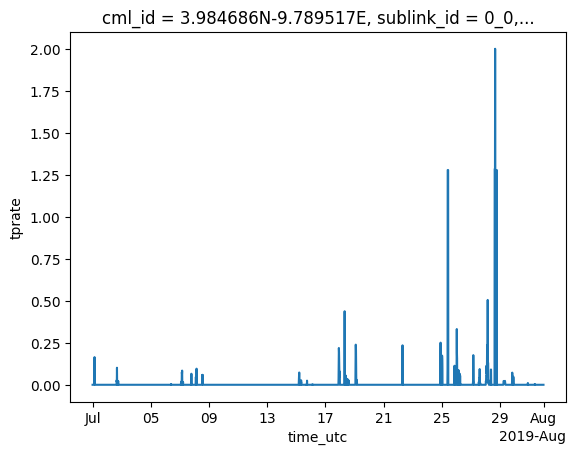

In [ ]:
#| hide
alpha = 0.3
R = (alpha * Rmax + (1 - alpha) * Rmin).to_dataset(name="tprate")
R.isel(cml_id=0, sublink_id=0).tprate.plot()

In [ ]:
#| export
def get_overeem_et_al_2013_min_max_nms_tprate(
        pia: xr.Dataset, # ds containing the minimum and maximum Path Integrated Attenuations (PIA)
        cfs: xr.Dataset, # ds containing `a` and `b`, k-R law coefficients as variable and `frequency` as dim
        cfs_assign_method: str = "nearest", # xr.sel method used to map the pia frequencies to the cfs freqs
        alpha: float = 0.3, # weighting factor between max and min sampling rain rates
        name_min: str = "pia_min", # Name of the variable containing minimum PIA
        name_max: str = "pia_max" # Name of the variable containing maximum PIA
    ) -> xr.Dataset:
    """Compute the rain rate using the Overeem et al. (2013) min/max sampling approach. """
    def kR(pia, a, b, l):
        return a * (pia / (l / 1e3)) ** b # Convert OpenSense standard length in meters to km
    H = pia > 0
    cfs = reindex_coefs(pia, cfs, method=cfs_assign_method)

    Rmin = kR(pia[name_min], cfs.a, cfs.b, pia.length).where(H[name_min], 0)
    Rmax = kR(pia[name_max], cfs.a, cfs.b, pia.length).where(H[name_max], 0)

    tprate = (alpha * Rmax + (1 - alpha) * Rmin).to_dataset(name="tprate")
    tprate["tprate"].attrs = {"long_name": "time_mean_path_averaged_rain_rate", "units": "mm/h"}
    return tprate

In [ ]:
tprate = get_overeem_et_al_2013_min_max_nms_tprate(pia, alcoba_2019_africa_coefs())
tprate

<xarray.Dataset> Size: 18MB
Dimensions:      (cml_id: 126, sublink_id: 6, time: 2964)
Coordinates: (10)
Data variables:
    tprate       (cml_id, sublink_id, time) float64 18MB 0.0 0.0 0.0 ... 0.0 0.0

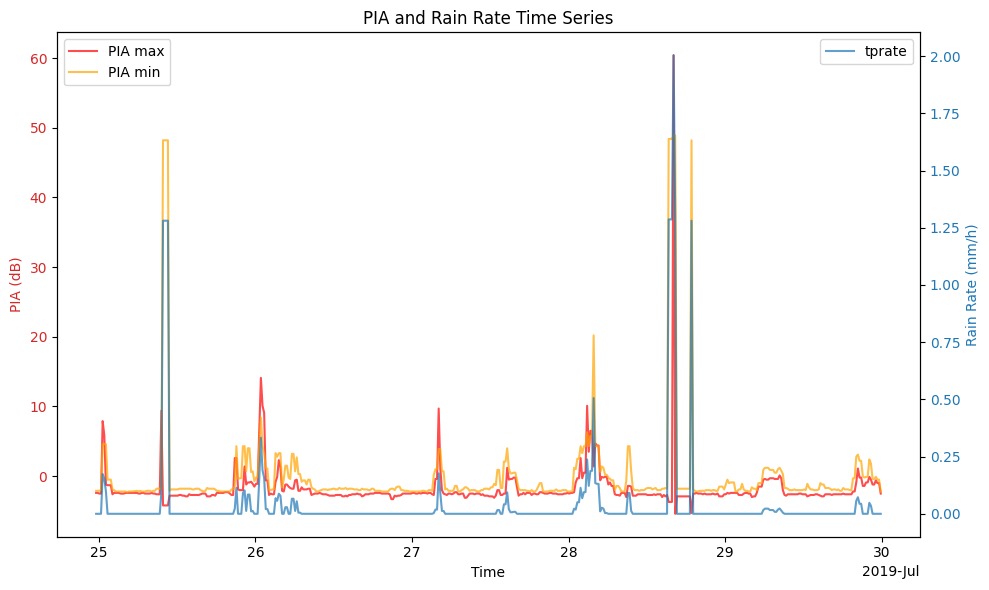

In [ ]:
#| echo:false
fig, ax1 = plt.subplots(figsize=(10, 6))

isel = dict(cml_id=0, sublink_id=0, time=slice(-7*24*4, -2*24*4))
# Plot PIA variables on left axis
pia.isel(**isel).pia_max.plot(ax=ax1, color='red', alpha=0.7, label='PIA max')
pia.isel(**isel).pia_min.plot(ax=ax1, color='orange', alpha=0.7, label='PIA min')
color = 'tab:red'
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')
ax1.set_xlabel('Time')
ax1.set_ylabel('PIA (dB)', color=color)
ax1.set_title("")


# Create second y-axis for tprate
ax2 = ax1.twinx()
color = 'tab:blue'
tprate.isel(**isel).tprate.plot(ax=ax2, color=color, alpha=0.7, label='tprate')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')
ax2.set_ylabel('Rain Rate (mm/h)', color=color)

plt.title('PIA and Rain Rate Time Series')
plt.tight_layout()
plt.show()

#### References

- Alcoba Kait, M. 2019. A contribution to rainfall observation in Africa from polarimetric weather radar and commercial microwave links. Ph.D. dissertation, Université Paul Sabatier – Toulouse III, 202 pages. https://tel-02955598 (accessed 2025‑11‑21).
- Overeem, A., H. Leijnse, and R. Uijlenhoet, 2013: Country-wide rainfall maps from cellular communication networks. Proceedings of the National Academy of Sciences, 110, 2741–2745, doi:10.1073/pnas.1217961110.
- Chwala, C., and H. Kunstmann, 2019: Commercial Microwave Link Networks for rainfall observation: Assessment of the current status and future challenges. WIREs Water, 6, doi:10.1002/wat2.1337. 

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()